In [1]:
import sys
from pathlib import Path

# Add the 'src' directory to the Python path
src_path = Path('../src').resolve()
sys.path.append(str(src_path))


from volume import *
from viewing_direction import * 
from utils import *
from aspire.volume import Volume
from aspire.utils import Rotation
import matplotlib.pyplot as plt 
import numpy as np
import numpy.linalg as LA 
import mrcfile 
from aspire.basis import FBBasis3D


In [2]:
with mrcfile.open('../data/emd_34948.map') as mrc:
    data = mrc.data

Vol = Volume(data)
ds_res = 64 
Vol = Vol.downsample(ds_res)
vol = Vol.asnumpy()
vol = vol[0]
n = vol.shape[0]

ell_max = 10 


print(vol.dtype)


float32


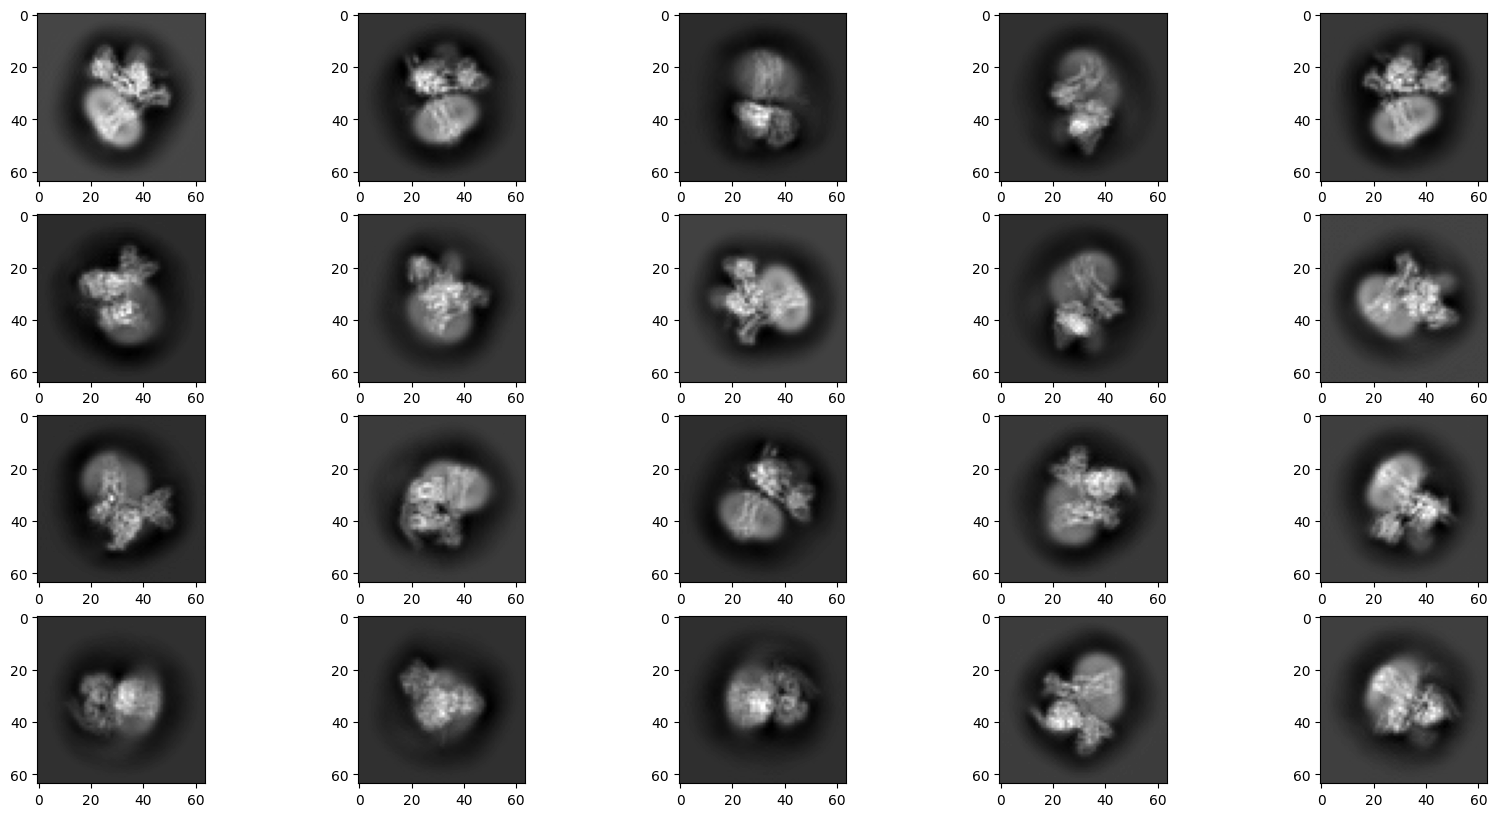

In [3]:
Rots = Rotation(np.eye(3)) 
Rots = Rots.generate_random_rotations(n=20)
Imgs = Vol.project(Rots)
Imgs.show(columns=5,colorbar=False)

In [4]:
# spherical bessel transform 
vol_coef, k_max, r0, indices = sphFB_transform(vol, ell_max)

In [5]:
# obtain the expanded volume 
vol_expand = coef_t_vol(vol_coef, ell_max, n, k_max, r0, indices)

In [6]:
# load the volume in aspire 
vol_expand = vol_expand.reshape([n,n,n])
Vol_expand = Volume(vol_expand)

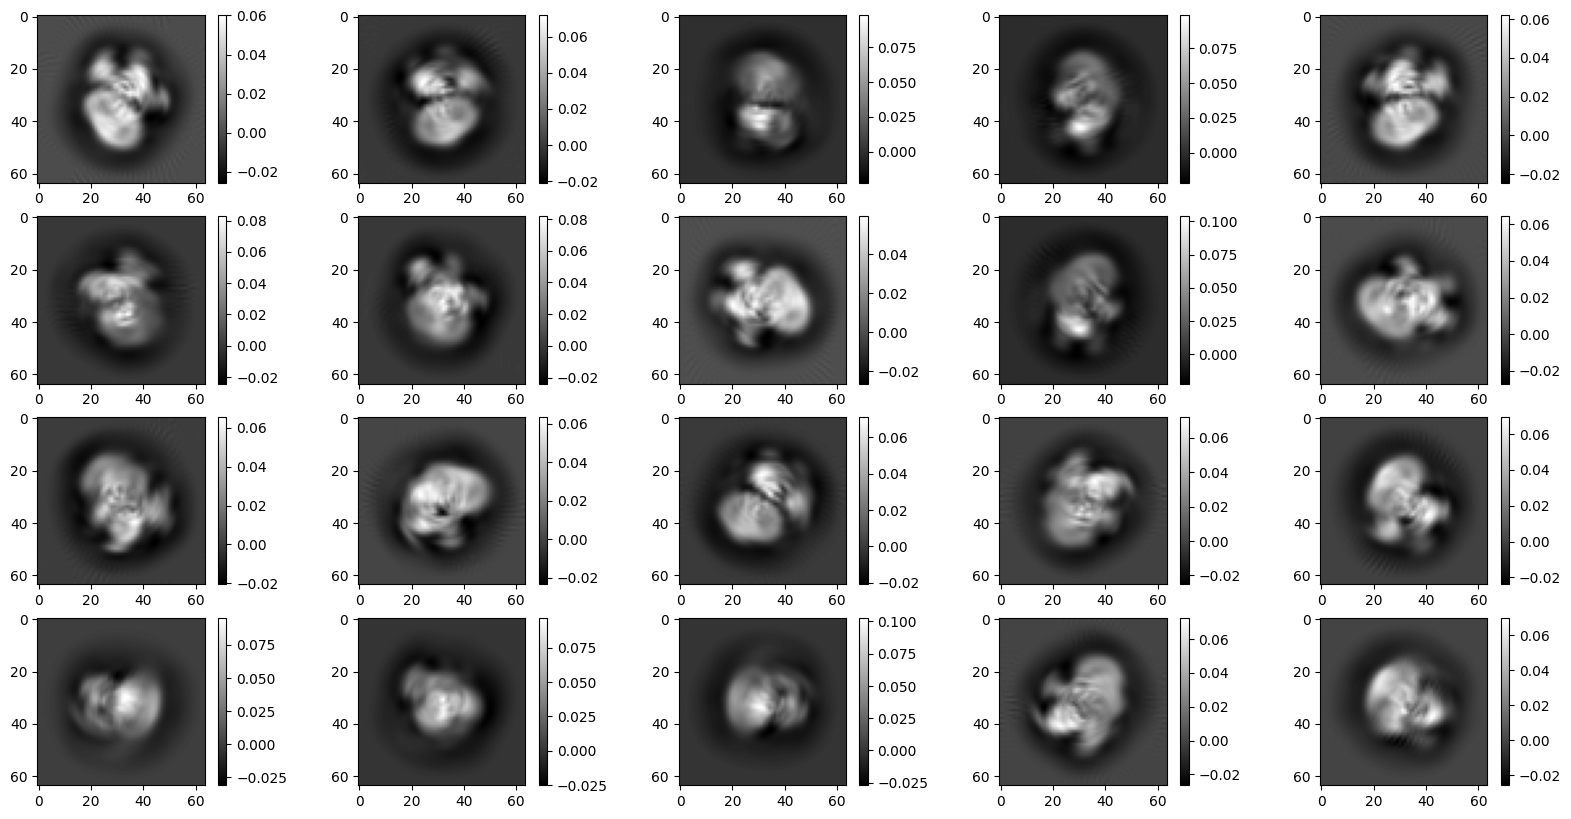

In [7]:
# use aspire to get projection image 
Imgs = Vol_expand.project(Rots)
Imgs.show(columns=5,colorbar=True)

2025-01-30 09:29:13,370 INFO [aspire.basis.fb_3d] Expanding 3D map in a spatial-domain Fourier–Bessel basis using the direct method.


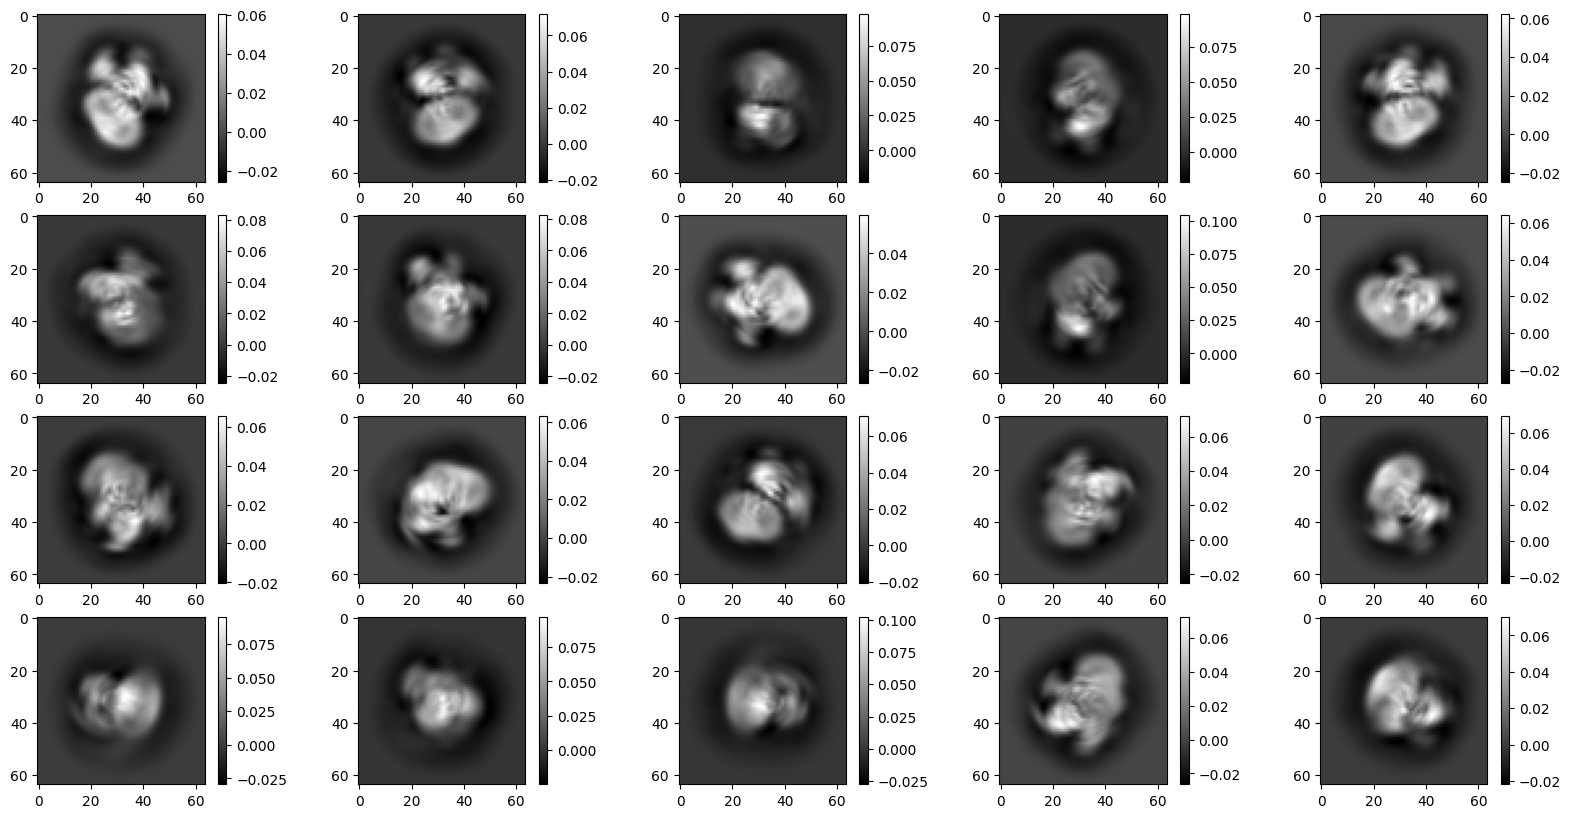

In [8]:
# compare with aspire's real sperical harmonic expansion 

fb_aspire = FBBasis3D(size=n, ell_max=ell_max)
fb_aspire_coef = fb_aspire.evaluate_t(Vol)
Vol_expand_aspire = fb_aspire.evaluate(fb_aspire_coef)
Imgs = Vol_expand_aspire.project(Rots)
Imgs.show(columns=5,colorbar=True)

In [9]:
vol_r_t_c, vol_c_t_r = get_sphFB_r_t_c_mat(ell_max, k_max, indices)

In [10]:
vol_coef_real = vol_c_t_r @ vol_coef
np.linalg.norm(np.imag(vol_coef_real),np.inf)/np.linalg.norm(vol_coef_real)

5.659484377901413e-09

||imag(Img)||/||Img||= 1.881835916871074e-08


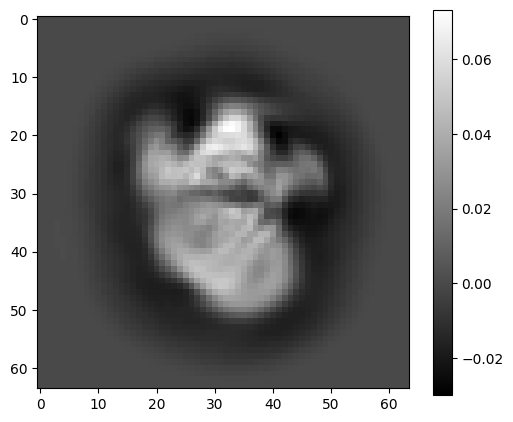

In [11]:
grid = get_2d_unif_grid(ds_res,1/ds_res)
grid = Grid_3d(xs=grid.xs, ys=grid.ys, zs=np.zeros(grid.ys.shape))
grid_proj = grid.get_rotated_grid(np.eye(3))

fft_img = sphFB_eval(vol_coef, ell_max, k_max, r0, indices, grid_proj)
fft_img = fft_img.reshape([ds_res,ds_res])
img = centered_ifft2(fft_img)/(ds_res)
print('||imag(Img)||/||Img||=',np.linalg.norm(np.imag(img),'fro') / np.linalg.norm(img,'fro'))


img = np.real(img)
plt.figure(figsize=(6, 5))
plt.imshow(img, cmap='gray',  aspect='equal')  
plt.colorbar()
plt.show()

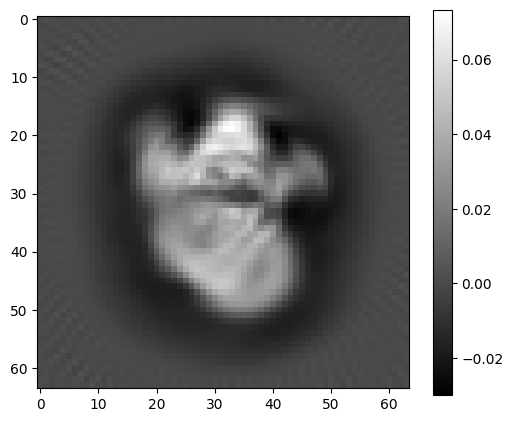

In [12]:
plt.figure(figsize=(6, 5))
plt.imshow(np.mean(vol_expand,2), cmap='gray',  aspect='equal')  
plt.colorbar()
plt.show()

In [13]:
_img = np.mean(vol_expand,2)


np.linalg.norm(img,'fro')/np.linalg.norm(_img,'fro')

0.9995409150837538

||imag(Img)||/||Img||= 3.433256258556446e-08


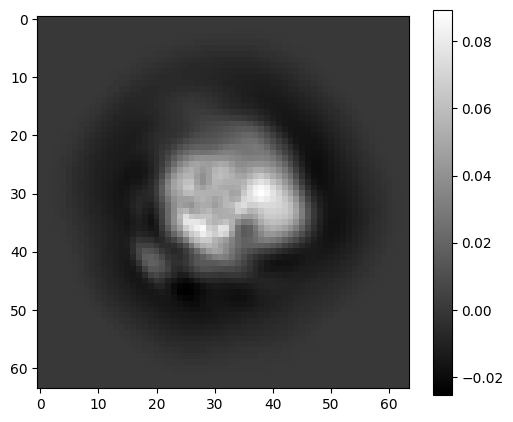

In [14]:
alpha = 0.38637945699603704
beta = 1.5573340717400395
gamma = 2.6451553852282235


Rot0 = Rz(alpha) @ Ry(beta) @ Rz(gamma)
grid_proj = grid.get_rotated_grid(Rot0)
fft_img = sphFB_eval(vol_coef, ell_max, k_max, r0, indices, grid_proj)
fft_img = fft_img.reshape([ds_res,ds_res])
img = centered_ifft2(fft_img)/(ds_res)
print('||imag(Img)||/||Img||=',np.linalg.norm(np.imag(img),'fro') / np.linalg.norm(img,'fro'))

img = np.real(img)
plt.figure(figsize=(6, 5))
plt.imshow(img, cmap='gray',  aspect='equal')  
plt.colorbar()
plt.show()


||imag(Img)||/||Img||= 3.433256258698897e-08


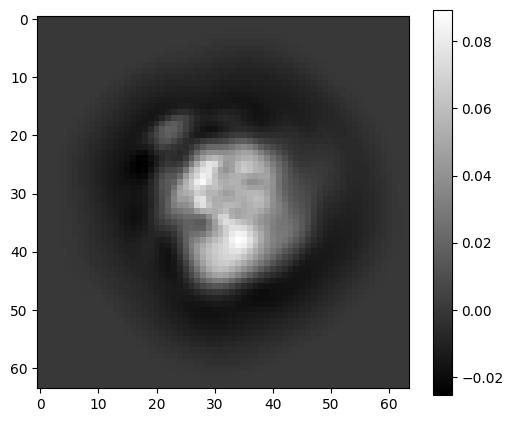

In [15]:
grid_proj = grid.get_rotated_grid(Rot0@Rz(np.pi/2))
fft_img = sphFB_eval(vol_coef, ell_max, k_max, r0, indices, grid_proj)
fft_img = fft_img.reshape([ds_res,ds_res])
img = centered_ifft2(fft_img)/(ds_res)
print('||imag(Img)||/||Img||=',np.linalg.norm(np.imag(img),'fro') / np.linalg.norm(img,'fro'))

img = np.real(img)
plt.figure(figsize=(6, 5))
plt.imshow(img, cmap='gray',  aspect='equal')  
plt.colorbar()
plt.show()

In [16]:
# check rotating spherical coefficients 

grid_proj = grid.get_rotated_grid(Rot0)
fft_img = sphFB_eval(vol_coef, ell_max, k_max, r0, indices, grid_proj)

# vol_coef_rot = np.zeros(vol_coef.shape, dtype=np.complex128)

# for ell in range(0,ell_max+1):
#     Dl = wignerD(ell,alpha,beta,gamma)
#     for k in range(0,k_max[ell]):
#         istart = indices[(ell,k,-ell)]
#         iend = indices[(ell,k,ell)]
#         vol_coef_rot[istart:iend+1] = np.conj(Dl).T @ vol_coef[istart:iend+1]

vol_coef_rot = rotate_sphFB(vol_coef, ell_max, k_max, indices, (alpha,beta,gamma))
_fft_img = sphFB_eval(vol_coef_rot, ell_max, k_max, r0, indices, grid)

np.linalg.norm(fft_img-_fft_img)/np.linalg.norm(fft_img)

3.730272411062909e-15

In [17]:
# check precomputation of basis matrix is correct 
grid = get_3d_unif_grid(n,rescale=1/ds_res)
evals = sphFB_eval(vol_coef, ell_max, k_max, r0, indices, grid)

Phi = precompute_sphFB_basis(ell_max, k_max, r0, indices, grid)
_evals = Phi @ vol_coef 

LA.norm(evals-_evals)/LA.norm(evals)

3.110884885030101e-15